# Modeling Notebook

## Libary Imports

In [1]:
## Import necessary libraries here
import os
import random
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from pathlib import Path
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline as SKPipeline
from sklearn.utils.class_weight import compute_class_weight
from matplotlib.ticker import ScalarFormatter

warnings.filterwarnings("ignore")

In [2]:
# set the random seed for reproducibility
RANDOM_SEED = 2025

# Establish output directories for images and tables developed
IMAGE_DIR = Path("../Images/")
TABLE_DIR = Path("../Tables/")

In [3]:
# create helper functions to save images and tables to respective directories
def save_figure(fig, filename: str, dpi: int = 300) -> None:
    """
    Save a matplotlib/seaborn figure to the Images directory.
    """
    filepath = IMAGE_DIR / filename
    fig.savefig(filepath, dpi=dpi, bbox_inches="tight")
    print(f"Saved figure to {filepath}")

def save_table(df, filename: str, index: bool = False) -> None:
    """
    Save a pandas or polars DataFrame to the Tables directory as CSV.
    """
    filepath = TABLE_DIR / filename

    # Handle polars vs pandas
    if isinstance(df, pl.DataFrame):
        df.write_csv(str(filepath))
    else:
        # assume pandas-like
        df.to_csv(str(filepath), index=index)

    print(f"Saved table to {filepath}")

## Data Access and Loading

In [4]:
# set the filepath to the parquet cleaned dataset
PATH = "../Data/Cleaned/Cleaned_Dataset.parquet"

# scan the parquet file with polars
scan = pl.scan_parquet(PATH)

df = scan.collect()
# drop the unneeded target columns for this 8-family analysis
df = df.drop(['Label', 'Label_Binary'])

# get schema
schema = df.schema

# cast Protocol_Type to categorical
df = df.with_columns(pl.col("Protocol_Type").cast(pl.Categorical))


In [5]:
# set feature and target variables
TARGET_FAMILY = 'Label_Family'

feature_columns = [col for col in df.columns if col != TARGET_FAMILY]

# categorical columns
CATEGORICAL_COLUMNS = ["Protocol_Type"]
# numerical columns
NUMERICAL_COLUMNS = [col for col, dtype in schema.items() if dtype in [pl.Int32, pl.Float32] and col != TARGET_FAMILY]

In [6]:
# convert to pandas for modeling
pdf = df.to_pandas()

X = pdf[feature_columns]
y = pdf[TARGET_FAMILY]

# Train / Test / Validation Split

In order to properly handle the imbalanced nature of the dataset the training data will be split and have a balanced nature to capture the minority class better. The test and validation sets will remain imbalanced to reflect real world data and to properly evaluate model performance.

In [7]:
# stratified split into train_full and temp (val+test)
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X,
    y,
    test_size=0.30,          # 70% train, 30% temp (val+test)
    stratify=y,
    random_state=RANDOM_SEED
)

# split temp into validation and test (both still imbalanced but representative)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,          # 15% val, 15% test overall
    stratify=y_temp,
    random_state=RANDOM_SEED
)

print("Class distribution (train_full):")
print(y_train_full.value_counts(normalize=True))

print("\nClass distribution (val):")
print(y_val.value_counts(normalize=True))

print("\nClass distribution (test):")
print(y_test.value_counts(normalize=True))

Class distribution (train_full):
Label_Family
DDOS           0.585191
DOS            0.198946
MIRAI          0.112314
BENIGN         0.049859
RECON          0.031205
SPOOFING       0.020760
WEB            0.001129
BRUTE_FORCE    0.000596
Name: proportion, dtype: float64

Class distribution (val):
Label_Family
DDOS           0.585191
DOS            0.198947
MIRAI          0.112314
BENIGN         0.049859
RECON          0.031205
SPOOFING       0.020760
WEB            0.001129
BRUTE_FORCE    0.000596
Name: proportion, dtype: float64

Class distribution (test):
Label_Family
DDOS           0.585191
DOS            0.198947
MIRAI          0.112314
BENIGN         0.049859
RECON          0.031205
SPOOFING       0.020760
WEB            0.001129
BRUTE_FORCE    0.000596
Name: proportion, dtype: float64


In [8]:
# building the balanced training set via undersampling majority classes

# combine X_train_full and y_train_full for easier group-wise sampling
train_full_df = X_train_full.copy()
train_full_df[TARGET_FAMILY] = y_train_full.values

# Count examples per class
class_counts = train_full_df[TARGET_FAMILY].value_counts()
print("\nTraining class counts (before balancing):")
print(class_counts)

# Smallest class size (wundersample all classes down to this)
min_count = class_counts.min()
print(f"\nUsing min_count = {min_count} samples per class for balanced training.")

balanced_parts = []

for label, count in class_counts.items():
    class_subset = train_full_df[train_full_df[TARGET_FAMILY] == label]
    
    # Sample without replacement down to min_count for majority classes,
    # keep all samples for classes already at min_count
    if count > min_count:
        sampled = class_subset.sample(
            n=min_count,
            random_state=RANDOM_SEED
        )
    else:
        sampled = class_subset
    
    balanced_parts.append(sampled)

# Concatenate and shuffle to create the final balanced training set
train_balanced_df = (
    pd.concat(balanced_parts, axis=0)
      .sample(frac=1.0, random_state=RANDOM_SEED)  # shuffle
      .reset_index(drop=True)
)

# Separate features and target for the balanced training data
X_train_bal = train_balanced_df.drop(columns=[TARGET_FAMILY])
y_train_bal = train_balanced_df[TARGET_FAMILY]

print("\nTraining class counts (after balancing):")
print(y_train_bal.value_counts())


Training class counts (before balancing):
Label_Family
DDOS           8604454
DOS            2925243
MIRAI          1651428
BENIGN          733116
RECON           458825
SPOOFING        305243
WEB              16595
BRUTE_FORCE       8764
Name: count, dtype: int64

Using min_count = 8764 samples per class for balanced training.

Training class counts (after balancing):
Label_Family
DDOS           8764
MIRAI          8764
SPOOFING       8764
BRUTE_FORCE    8764
WEB            8764
DOS            8764
RECON          8764
BENIGN         8764
Name: count, dtype: int64


In [9]:
# Encode target labels
label_encoder = LabelEncoder()
y_train_bal_enc = label_encoder.fit_transform(y_train_bal)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

class_names = label_encoder.classes_
n_classes = len(class_names)

## LightGBM Model

In [10]:
# Preprocessing: ColumnTransformer for numeric + categorical
# Numeric: passthrough (trees/boosting don't need scaling)
# Categorical: OneHotEncode Protocol_Type
numeric_features = NUMERICAL_COLUMNS
categorical_features = CATEGORICAL_COLUMNS

preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

# Define the LightGBM classifier
lgbm_clf = LGBMClassifier(
    objective="multiclass",
    random_state=RANDOM_SEED,
    n_estimators=200,
    learning_rate=0.1,
    n_jobs=-1
)

# Build the full modeling pipeline
lgbm_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", lgbm_clf),
    ]
)

# Cross-validation on the balanced training data
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_SEED
)

cv_results = cross_validate(
    lgbm_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_df = pd.DataFrame(cv_results)
cv_summary = cv_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_summary.columns = ["mean", "std"]
print("\nCross-validation performance (balanced training set):")
print(cv_summary)

# Save CV results and summary
# save_table(cv_df, "LightGBM_CV_Results.csv", index=False)
# save_table(cv_summary, "LightGBM_CV_Summary.csv", index=True)

# fit the LightGBM pipeline on the full balanced training set
lgbm_pipeline.fit(X_train_bal, y_train_bal_enc)


Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.757203  0.002224
test_f1_macro            0.757755  0.002040
test_f1_weighted         0.757754  0.002036
test_precision_macro     0.760958  0.002294
test_precision_weighted  0.760958  0.002290
test_recall_macro        0.757203  0.002229
test_recall_weighted     0.757203  0.002224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3916
[LightGBM] [Info] Number of data points in the train set: 70112, number of used features: 38
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training f

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



=== VAL SET PERFORMANCE ===
Accuracy            : 0.7798
Precision (macro)   : 0.6415
Precision (weighted): 0.8441
Recall (macro)      : 0.7581
Recall (weighted)   : 0.7798
F1 (macro)          : 0.6313
F1 (weighted)       : 0.7962

Classification Report (Val):
              precision    recall  f1-score   support

      BENIGN     0.8767    0.7518    0.8094    157096
 BRUTE_FORCE     0.0537    0.6651    0.0994      1878
        DDOS     0.9287    0.7285    0.8165   1843812
         DOS     0.5122    0.8360    0.6352    626838
       MIRAI     0.9948    0.9969    0.9958    353877
       RECON     0.7725    0.6111    0.6824     98320
    SPOOFING     0.9211    0.8449    0.8813     65409
         WEB     0.0727    0.6302    0.1303      3556

    accuracy                         0.7798   3150786
   macro avg     0.6415    0.7581    0.6313   3150786
weighted avg     0.8441    0.7798    0.7962   3150786



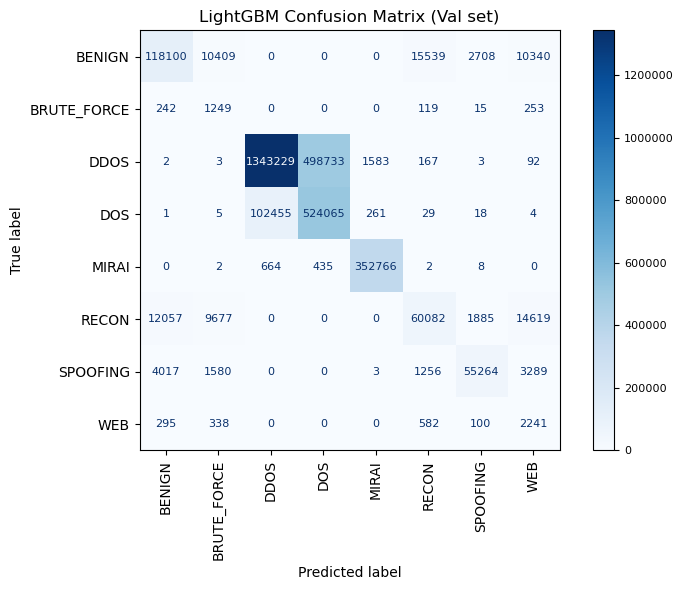


=== TEST SET PERFORMANCE ===
Accuracy            : 0.7798
Precision (macro)   : 0.6410
Precision (weighted): 0.8440
Recall (macro)      : 0.7573
Recall (weighted)   : 0.7798
F1 (macro)          : 0.6311
F1 (weighted)       : 0.7961

Classification Report (Test):
              precision    recall  f1-score   support

      BENIGN     0.8763    0.7506    0.8086    157096
 BRUTE_FORCE     0.0536    0.6592    0.0991      1878
        DDOS     0.9287    0.7286    0.8166   1843812
         DOS     0.5122    0.8360    0.6352    626838
       MIRAI     0.9947    0.9970    0.9959    353878
       RECON     0.7695    0.6100    0.6805     98319
    SPOOFING     0.9205    0.8470    0.8823     65409
         WEB     0.0727    0.6296    0.1303      3556

    accuracy                         0.7798   3150786
   macro avg     0.6410    0.7573    0.6311   3150786
weighted avg     0.8440    0.7798    0.7961   3150786



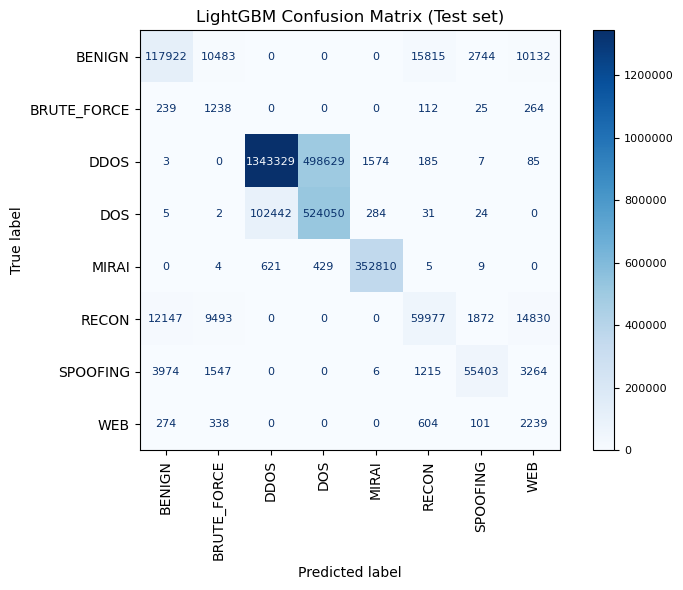

In [11]:
# helper function for evaluation on val/test
def evaluate_multiclass_model(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass classifier with accuracy, precision, recall,
    macro/weighted F1, classification report, and confusion matrix (saved as image).
    """
    y_pred_enc = pipeline.predict(X)
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nClassification Report ({split_name}):")
    print(report)

    # Save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    # save_table(report_df, f"LightGBM_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix (normalized by true labels)
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)
    # 1) Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)  # adjust to taste (e.g., 7, 9, etc.)
    # 2) Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f"LightGBM Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    # save_figure(fig, f"LightGBM_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }

# evaluate on validation and test sets (note: these are imbalanced and realistic)
val_results = evaluate_multiclass_model(
    lgbm_pipeline,
    X_val,
    y_val_enc,
    split_name="Val"
)

test_results = evaluate_multiclass_model(
    lgbm_pipeline,
    X_test,
    y_test_enc,
    split_name="Test"
)

## Random Forest Model

In [12]:
# define the Random Forest classifier
rf_clf = RandomForestClassifier(
    n_estimators=300,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

# build the full modeling pipeline for Random Forest
rf_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor),  # same preprocessor as LightGBM
        ("model", rf_clf),
    ]
)

# cross-validation on the balanced training data (reuse the same cv object)
cv_results_rf = cross_validate(
    rf_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_rf_df = pd.DataFrame(cv_results_rf)
cv_rf_summary = cv_rf_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_rf_summary.columns = ["mean", "std"]

print("\nRandom Forest Cross-validation performance (balanced training set):")
print(cv_rf_summary)

# Save CV results and summary for Random Forest
# save_table(cv_rf_df, "RandomForest_CV_Results.csv", index=False)
# save_table(cv_rf_summary, "RandomForest_CV_Summary.csv", index=True)

# Fit the Random Forest pipeline on the full balanced training set
rf_pipeline.fit(X_train_bal, y_train_bal_enc)


Random Forest Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.743311  0.001605
test_f1_macro            0.744347  0.001813
test_f1_weighted         0.744347  0.001817
test_precision_macro     0.747351  0.002239
test_precision_weighted  0.747351  0.002242
test_recall_macro        0.743311  0.001600
test_recall_weighted     0.743311  0.001605


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



=== RANDOM FOREST VAL SET PERFORMANCE ===
Accuracy            : 0.7692
Precision (macro)   : 0.6342
Precision (weighted): 0.8316
Recall (macro)      : 0.7454
Recall (weighted)   : 0.7692
F1 (macro)          : 0.6220
F1 (weighted)       : 0.7862

Random Forest Classification Report (Val):
              precision    recall  f1-score   support

      BENIGN     0.8740    0.7293    0.7951    157096
 BRUTE_FORCE     0.0490    0.6422    0.0910      1878
        DDOS     0.9134    0.7260    0.8090   1843812
         DOS     0.4982    0.7974    0.6132    626838
       MIRAI     0.9935    0.9971    0.9953    353877
       RECON     0.7590    0.6050    0.6733     98320
    SPOOFING     0.9185    0.8380    0.8764     65409
         WEB     0.0679    0.6280    0.1225      3556

    accuracy                         0.7692   3150786
   macro avg     0.6342    0.7454    0.6220   3150786
weighted avg     0.8316    0.7692    0.7862   3150786



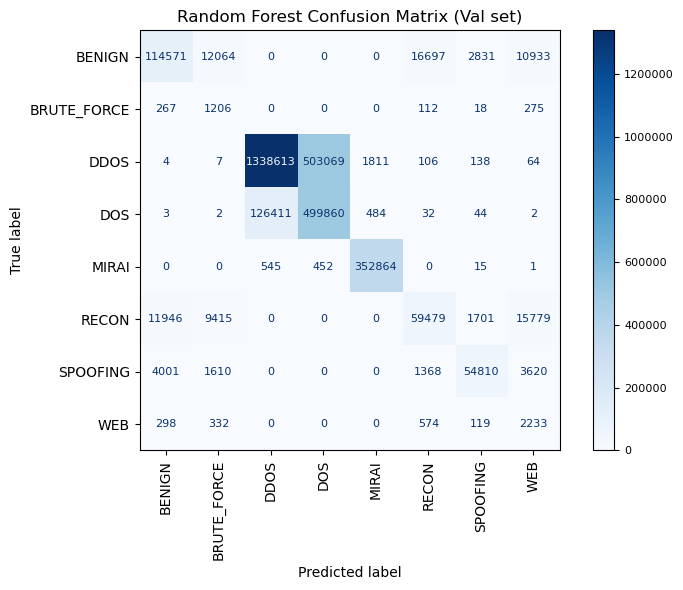


=== RANDOM FOREST TEST SET PERFORMANCE ===
Accuracy            : 0.7696
Precision (macro)   : 0.6341
Precision (weighted): 0.8321
Recall (macro)      : 0.7438
Recall (weighted)   : 0.7696
F1 (macro)          : 0.6219
F1 (weighted)       : 0.7866

Random Forest Classification Report (Test):
              precision    recall  f1-score   support

      BENIGN     0.8740    0.7281    0.7944    157096
 BRUTE_FORCE     0.0482    0.6305    0.0896      1878
        DDOS     0.9140    0.7261    0.8093   1843812
         DOS     0.4988    0.7989    0.6141    626838
       MIRAI     0.9936    0.9973    0.9954    353878
       RECON     0.7578    0.6055    0.6732     98319
    SPOOFING     0.9188    0.8392    0.8772     65409
         WEB     0.0675    0.6251    0.1218      3556

    accuracy                         0.7696   3150786
   macro avg     0.6341    0.7438    0.6219   3150786
weighted avg     0.8321    0.7696    0.7866   3150786



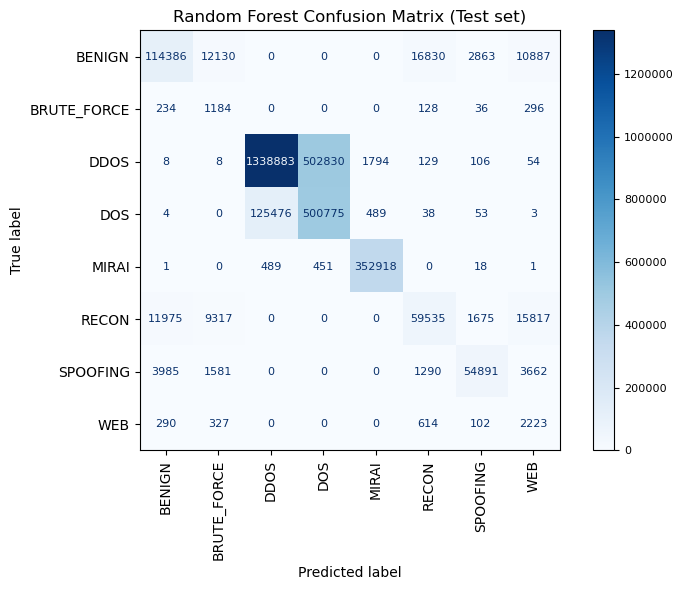

In [13]:
def evaluate_multiclass_model_rf(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass Random Forest classifier with accuracy, precision,
    recall, macro/weighted F1, classification report, and confusion matrix.
    """
    y_pred_enc = pipeline.predict(X)
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== RANDOM FOREST {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nRandom Forest Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    # save_table(report_df, f"RandomForest_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix (normalized by true labels)
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"Random Forest Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    # save_figure(fig, f"RandomForest_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }


# Evaluate Random Forest on validation and test sets

rf_val_results = evaluate_multiclass_model_rf(
    rf_pipeline,
    X_val,
    y_val_enc,
    split_name="Val"
)

rf_test_results = evaluate_multiclass_model_rf(
    rf_pipeline,
    X_test,
    y_test_enc,
    split_name="Test"
)

## CatBoost Model

In [14]:
# CatBoost model development
# define the CatBoost classifier
cat_clf = CatBoostClassifier(
    loss_function="MultiClass",
    eval_metric="Accuracy",
    iterations=300,
    learning_rate=0.1,
    depth=8,
    l2_leaf_reg=3.0,
    bootstrap_type="Bernoulli",
    subsample=0.8,
    random_state=RANDOM_SEED,
    thread_count=-1,
    verbose=0,
    allow_writing_files=False
)

# build the full modeling pipeline for CatBoost
cat_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor),  # same ColumnTransformer as LightGBM / RF
        ("model", cat_clf),
    ]
)

# cross-validation on the balanced training data (reuse the same cv object)
cv_results_cat = cross_validate(
    cat_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_cat_df = pd.DataFrame(cv_results_cat)
cv_cat_summary = cv_cat_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_cat_summary.columns = ["mean", "std"]

print("\nCatBoost Cross-validation performance (balanced training set):")
print(cv_cat_summary)

# save CV results and summary for CatBoost
# save_table(cv_cat_df, "CatBoost_CV_Results.csv", index=False)
# save_table(cv_cat_summary, "CatBoost_CV_Summary.csv", index=True)

# fit the CatBoost pipeline on the full balanced training set
cat_pipeline.fit(X_train_bal, y_train_bal_enc)


CatBoost Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.753737  0.002772
test_f1_macro            0.754112  0.002719
test_f1_weighted         0.754112  0.002720
test_precision_macro     0.758211  0.003307
test_precision_weighted  0.758211  0.003307
test_recall_macro        0.753737  0.002771
test_recall_weighted     0.753737  0.002772


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



=== CATBOOST VAL SET PERFORMANCE ===
Accuracy            : 0.7743
Precision (macro)   : 0.6387
Precision (weighted): 0.8463
Recall (macro)      : 0.7540
Recall (weighted)   : 0.7743
F1 (macro)          : 0.6267
F1 (weighted)       : 0.7915

CatBoost Classification Report (Val):
              precision    recall  f1-score   support

      BENIGN     0.8730    0.7460    0.8045    157096
 BRUTE_FORCE     0.0506    0.6534    0.0940      1878
        DDOS     0.9359    0.7135    0.8097   1843812
         DOS     0.5050    0.8560    0.6352    626838
       MIRAI     0.9931    0.9967    0.9949    353877
       RECON     0.7750    0.5980    0.6751     98320
    SPOOFING     0.9077    0.8469    0.8763     65409
         WEB     0.0690    0.6212    0.1243      3556

    accuracy                         0.7743   3150786
   macro avg     0.6387    0.7540    0.6267   3150786
weighted avg     0.8463    0.7743    0.7915   3150786



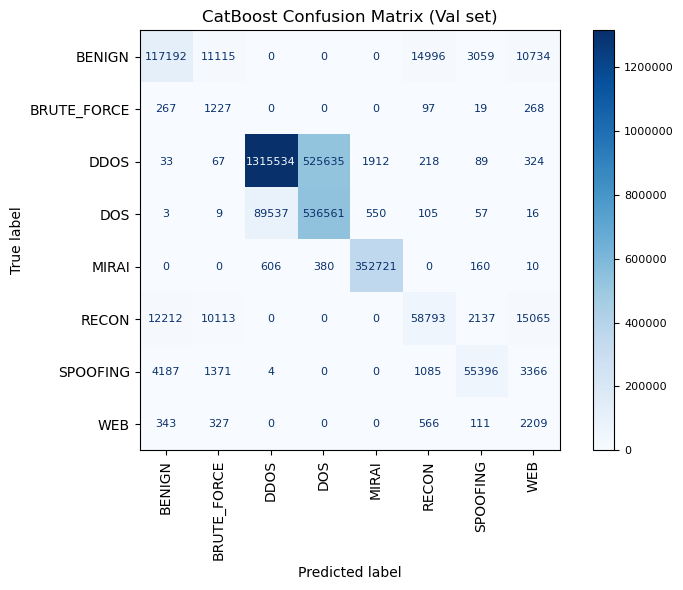


=== CATBOOST TEST SET PERFORMANCE ===
Accuracy            : 0.7744
Precision (macro)   : 0.6384
Precision (weighted): 0.8463
Recall (macro)      : 0.7527
Recall (weighted)   : 0.7744
F1 (macro)          : 0.6267
F1 (weighted)       : 0.7916

CatBoost Classification Report (Test):
              precision    recall  f1-score   support

      BENIGN     0.8740    0.7464    0.8051    157096
 BRUTE_FORCE     0.0509    0.6496    0.0945      1878
        DDOS     0.9359    0.7135    0.8097   1843812
         DOS     0.5051    0.8561    0.6353    626838
       MIRAI     0.9929    0.9968    0.9948    353878
       RECON     0.7725    0.5990    0.6748     98319
    SPOOFING     0.9074    0.8481    0.8768     65409
         WEB     0.0683    0.6122    0.1229      3556

    accuracy                         0.7744   3150786
   macro avg     0.6384    0.7527    0.6267   3150786
weighted avg     0.8463    0.7744    0.7916   3150786



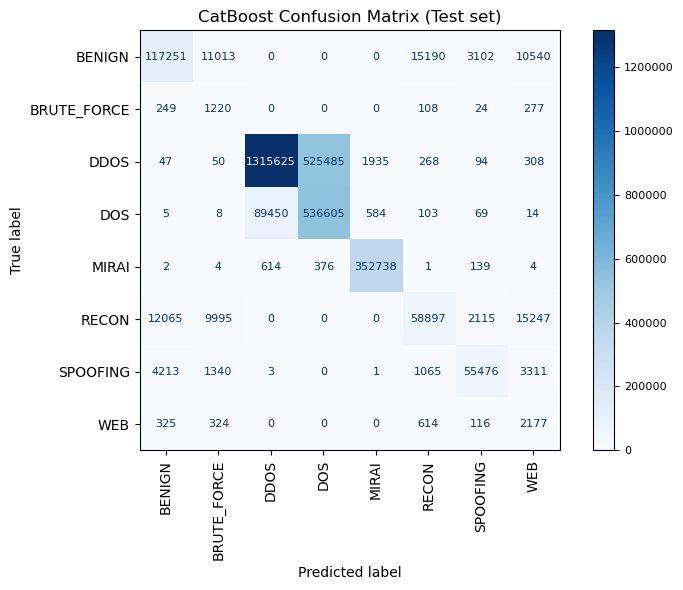

In [15]:
# helper function to evaluate validation and testing of catboost model
def evaluate_multiclass_model_catboost(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass CatBoost classifier with accuracy, precision,
    recall, macro/weighted F1, classification report, and confusion matrix.
    """
    y_pred_enc = pipeline.predict(X)
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== CATBOOST {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nCatBoost Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    # save_table(report_df, f"CatBoost_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"CatBoost Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    # save_figure(fig, f"CatBoost_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }

# Evaluate CatBoost on validation and test sets

cat_val_results = evaluate_multiclass_model_catboost(
    cat_pipeline,
    X_val,
    y_val_enc,
    split_name="Val"
)

cat_test_results = evaluate_multiclass_model_catboost(
    cat_pipeline,
    X_test,
    y_test_enc,
    split_name="Test"
)

## Adaboost Model

In [16]:
# AdaBoost model development
# define the AdaBoost classifier
ada_clf = AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=RANDOM_SEED
)

# build the full modeling pipeline for AdaBoost
ada_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor),  # same ColumnTransformer as LightGBM / RF / CatBoost
        ("model", ada_clf),
    ]
)

# cross-validation on the balanced training data (reuse the same cv object)
cv_results_ada = cross_validate(
    ada_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_ada_df = pd.DataFrame(cv_results_ada)
cv_ada_summary = cv_ada_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_ada_summary.columns = ["mean", "std"]

print("\nAdaBoost Cross-validation performance (balanced training set):")
print(cv_ada_summary)

# optionally save CV results and summary for AdaBoost
# save_table(cv_ada_df, "AdaBoost_CV_Results.csv", index=False)
# save_table(cv_ada_summary, "AdaBoost_CV_Summary.csv", index=True)

# fit the AdaBoost pipeline on the full balanced training set
ada_pipeline.fit(X_train_bal, y_train_bal_enc)


AdaBoost Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.290706  0.002431
test_f1_macro            0.167960  0.002912
test_f1_weighted         0.167954  0.002921
test_precision_macro     0.193414  0.000110
test_precision_weighted  0.193411  0.000118
test_recall_macro        0.290721  0.002420
test_recall_weighted     0.290706  0.002431


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



=== ADABOOST VAL SET PERFORMANCE ===
Accuracy            : 0.2063
Precision (macro)   : 0.1535
Precision (weighted): 0.0649
Recall (macro)      : 0.2906
Recall (weighted)   : 0.2063
F1 (macro)          : 0.1082
F1 (weighted)       : 0.0825

AdaBoost Classification Report (Val):
              precision    recall  f1-score   support

      BENIGN     0.0000    0.0000    0.0000    157096
 BRUTE_FORCE     0.0061    1.0000    0.0122      1878
        DDOS     0.0000    0.0000    0.0000   1843812
         DOS     0.2220    0.9999    0.3633    626838
       MIRAI     0.0000    0.0000    0.0000    353877
       RECON     0.0000    0.0000    0.0000     98320
    SPOOFING     1.0000    0.3246    0.4902     65409
         WEB     0.0000    0.0000    0.0000      3556

    accuracy                         0.2063   3150786
   macro avg     0.1535    0.2906    0.1082   3150786
weighted avg     0.0649    0.2063    0.0825   3150786



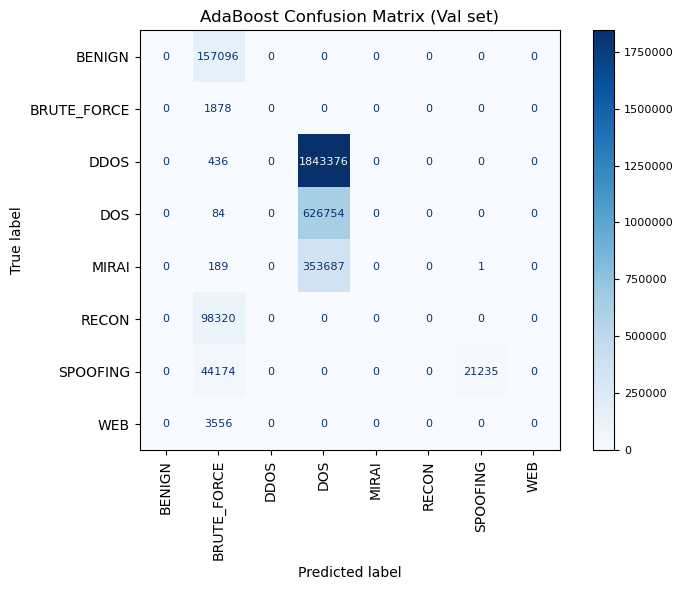


=== ADABOOST TEST SET PERFORMANCE ===
Accuracy            : 0.2063
Precision (macro)   : 0.1535
Precision (weighted): 0.0649
Recall (macro)      : 0.2910
Recall (weighted)   : 0.2063
F1 (macro)          : 0.1087
F1 (weighted)       : 0.0825

AdaBoost Classification Report (Test):
              precision    recall  f1-score   support

      BENIGN     0.0000    0.0000    0.0000    157096
 BRUTE_FORCE     0.0061    1.0000    0.0122      1878
        DDOS     0.0000    0.0000    0.0000   1843812
         DOS     0.2220    0.9998    0.3633    626838
       MIRAI     0.0000    0.0000    0.0000    353878
       RECON     0.0000    0.0000    0.0000     98319
    SPOOFING     1.0000    0.3282    0.4942     65409
         WEB     0.0000    0.0000    0.0000      3556

    accuracy                         0.2063   3150786
   macro avg     0.1535    0.2910    0.1087   3150786
weighted avg     0.0649    0.2063    0.0825   3150786



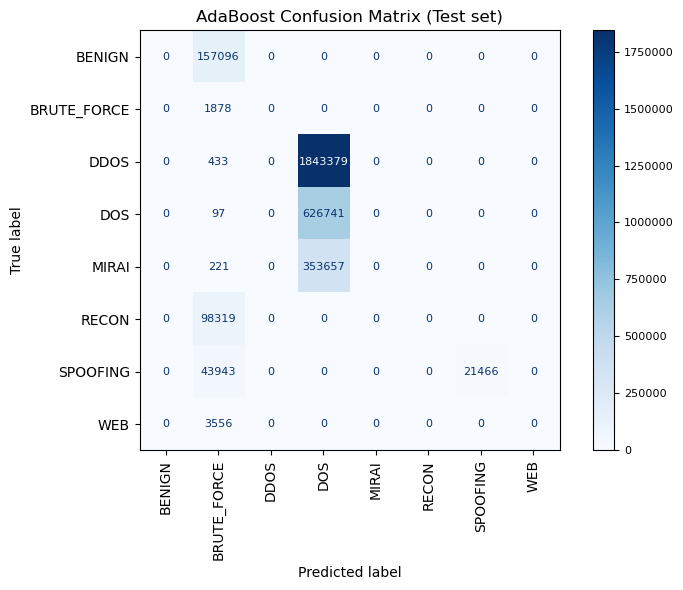

In [17]:
# helper function to evaluate validation and testing of AdaBoost model
def evaluate_multiclass_model_adaboost(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass AdaBoost classifier with accuracy, precision,
    recall, macro/weighted F1, classification report, and confusion matrix.
    """
    y_pred_enc = pipeline.predict(X)
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== ADABOOST {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nAdaBoost Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    # save_table(report_df, f"AdaBoost_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"AdaBoost Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    # save_figure(fig, f"AdaBoost_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }


# Evaluate AdaBoost on validation and test sets

ada_val_results = evaluate_multiclass_model_adaboost(
    ada_pipeline,
    X_val,
    y_val_enc,
    split_name="Val"
)

ada_test_results = evaluate_multiclass_model_adaboost(
    ada_pipeline,
    X_test,
    y_test_enc,
    split_name="Test"
)

## XGBoost Model

In [18]:
# XGBoost model development
# define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective="multi:softprob",   # multiclass probability output
    eval_metric="mlogloss",
    n_estimators=300,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=RANDOM_SEED,
    tree_method="hist"            # efficient histogram-based algorithm
)

# build the full modeling pipeline for XGBoost
xgb_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor),  # same ColumnTransformer as LightGBM / RF / CatBoost / AdaBoost
        ("model", xgb_clf),
    ]
)

# cross-validation on the balanced training data (reuse the same cv object)
cv_results_xgb = cross_validate(
    xgb_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_xgb_df = pd.DataFrame(cv_results_xgb)
cv_xgb_summary = cv_xgb_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_xgb_summary.columns = ["mean", "std"]

print("\nXGBoost Cross-validation performance (balanced training set):")
print(cv_xgb_summary)

# optionally save CV results and summary for XGBoost
# save_table(cv_xgb_df, "XGBoost_CV_Results.csv", index=False)
# save_table(cv_xgb_summary, "XGBoost_CV_Summary.csv", index=True)

# fit the XGBoost pipeline on the full balanced training set
xgb_pipeline.fit(X_train_bal, y_train_bal_enc)


XGBoost Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.755648  0.003359
test_f1_macro            0.756267  0.003284
test_f1_weighted         0.756267  0.003281
test_precision_macro     0.759184  0.003727
test_precision_weighted  0.759184  0.003724
test_recall_macro        0.755648  0.003363
test_recall_weighted     0.755648  0.003359


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



=== XGBOOST VAL SET PERFORMANCE ===
Accuracy            : 0.7766
Precision (macro)   : 0.6406
Precision (weighted): 0.8421
Recall (macro)      : 0.7571
Recall (weighted)   : 0.7766
F1 (macro)          : 0.6294
F1 (weighted)       : 0.7933

XGBoost Classification Report (Val):
              precision    recall  f1-score   support

      BENIGN     0.8781    0.7473    0.8074    157096
 BRUTE_FORCE     0.0516    0.6576    0.0956      1878
        DDOS     0.9269    0.7248    0.8135   1843812
         DOS     0.5078    0.8319    0.6306    626838
       MIRAI     0.9933    0.9972    0.9952    353877
       RECON     0.7715    0.6093    0.6809     98320
    SPOOFING     0.9229    0.8435    0.8814     65409
         WEB     0.0726    0.6451    0.1306      3556

    accuracy                         0.7766   3150786
   macro avg     0.6406    0.7571    0.6294   3150786
weighted avg     0.8421    0.7766    0.7933   3150786



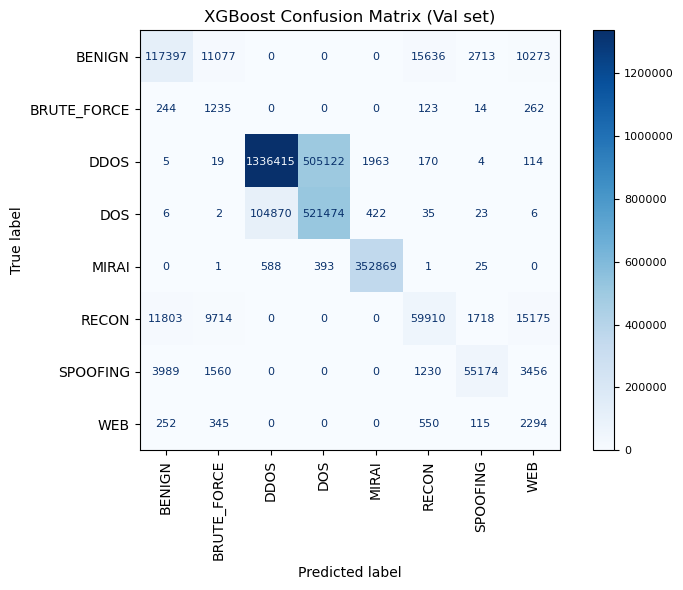


=== XGBOOST TEST SET PERFORMANCE ===
Accuracy            : 0.7770
Precision (macro)   : 0.6406
Precision (weighted): 0.8425
Recall (macro)      : 0.7571
Recall (weighted)   : 0.7770
F1 (macro)          : 0.6295
F1 (weighted)       : 0.7937

XGBoost Classification Report (Test):
              precision    recall  f1-score   support

      BENIGN     0.8790    0.7461    0.8071    157096
 BRUTE_FORCE     0.0519    0.6608    0.0962      1878
        DDOS     0.9273    0.7252    0.8139   1843812
         DOS     0.5084    0.8327    0.6313    626838
       MIRAI     0.9932    0.9972    0.9952    353878
       RECON     0.7701    0.6106    0.6812     98319
    SPOOFING     0.9231    0.8445    0.8821     65409
         WEB     0.0719    0.6395    0.1292      3556

    accuracy                         0.7770   3150786
   macro avg     0.6406    0.7571    0.6295   3150786
weighted avg     0.8425    0.7770    0.7937   3150786



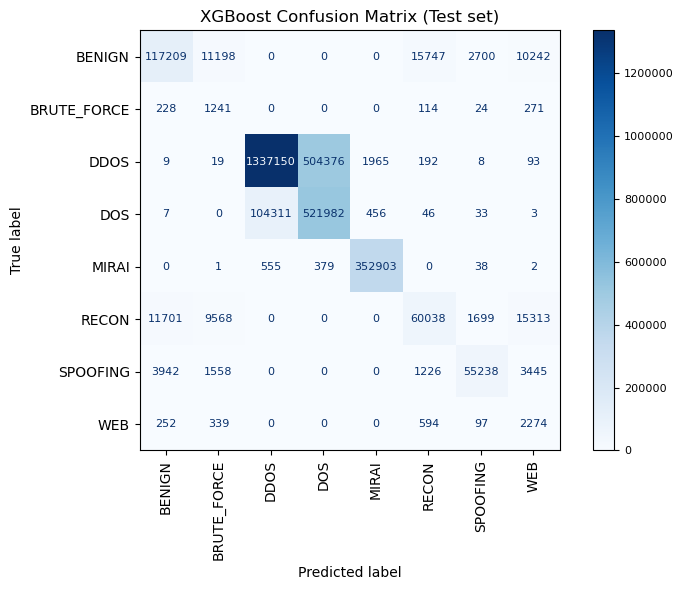

In [19]:
# helper function to evaluate validation and testing of XGBoost model
def evaluate_multiclass_model_xgboost(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass XGBoost classifier with accuracy, precision,
    recall, macro/weighted F1, classification report, and confusion matrix.
    """
    y_pred_enc = pipeline.predict(X)
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== XGBOOST {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nXGBoost Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    # save_table(report_df, f"XGBoost_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"XGBoost Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    # save_figure(fig, f"XGBoost_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }


# Evaluate XGBoost on validation and test sets

xgb_val_results = evaluate_multiclass_model_xgboost(
    xgb_pipeline,
    X_val,
    y_val_enc,
    split_name="Val"
)

xgb_test_results = evaluate_multiclass_model_xgboost(
    xgb_pipeline,
    X_test,
    y_test_enc,
    split_name="Test"
)

## Logistic Regression Model

In [20]:
# Multiclass Logistic Regression model development

# for linear models we want scaled numeric features.
# build a dedicated preprocessor for Logistic Regression
numeric_transformer_lr = RobustScaler()
categorical_transformer_lr = OneHotEncoder(handle_unknown="ignore")

preprocessor_lr = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_lr, numeric_features),
        ("cat", categorical_transformer_lr, categorical_features),
    ]
)

# Define the Logistic Regression classifier
logreg_clf = LogisticRegression(
    multi_class="multinomial",
    solver="saga",
    penalty="l2",
    max_iter=1000,
    n_jobs=-1,
    random_state=RANDOM_SEED
)

# build the full modeling pipeline for Logistic Regression
logreg_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor_lr),
        ("model", logreg_clf),
    ]
)

# Cross-validation on the balanced training data (reuse the same cv object)
cv_results_logreg = cross_validate(
    logreg_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_logreg_df = pd.DataFrame(cv_results_logreg)
cv_logreg_summary = cv_logreg_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_logreg_summary.columns = ["mean", "std"]

print("\nLogistic Regression Cross-validation performance (balanced training set):")
print(cv_logreg_summary)

# Optionally save CV results and summary for Logistic Regression
# save_table(cv_logreg_df, "LogisticRegression_CV_Results.csv", index=False)
# save_table(cv_logreg_summary, "LogisticRegression_CV_Summary.csv", index=True)

# Fit the Logistic Regression pipeline on the full balanced training set
logreg_pipeline.fit(X_train_bal, y_train_bal_enc)


Logistic Regression Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.361750  0.056925
test_f1_macro            0.299249  0.072345
test_f1_weighted         0.299245  0.072332
test_precision_macro     0.327478  0.062506
test_precision_weighted  0.327475  0.062499
test_recall_macro        0.361755  0.056943
test_recall_weighted     0.361750  0.056925


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



=== LOGISTIC REGRESSION VAL SET PERFORMANCE ===
Accuracy            : 0.5521
Precision (macro)   : 0.3455
Precision (weighted): 0.6244
Recall (macro)      : 0.3396
Recall (weighted)   : 0.5521
F1 (macro)          : 0.2854
F1 (weighted)       : 0.5598

Logistic Regression Classification Report (Val):
              precision    recall  f1-score   support

      BENIGN     0.3272    0.5084    0.3981    157096
 BRUTE_FORCE     0.0110    0.1368    0.0204      1878
        DDOS     0.7845    0.5579    0.6521   1843812
         DOS     0.3022    0.5024    0.3774    626838
       MIRAI     0.6113    0.8811    0.7218    353877
       RECON     0.5353    0.0348    0.0654     98320
    SPOOFING     0.1656    0.0032    0.0062     65409
         WEB     0.0268    0.0925    0.0416      3556

    accuracy                         0.5521   3150786
   macro avg     0.3455    0.3396    0.2854   3150786
weighted avg     0.6244    0.5521    0.5598   3150786



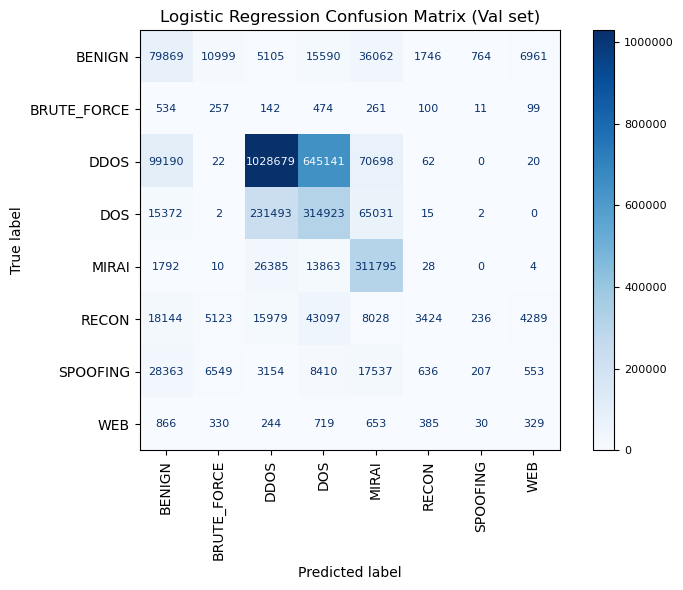


=== LOGISTIC REGRESSION TEST SET PERFORMANCE ===
Accuracy            : 0.5519
Precision (macro)   : 0.3422
Precision (weighted): 0.6238
Recall (macro)      : 0.3388
Recall (weighted)   : 0.5519
F1 (macro)          : 0.2848
F1 (weighted)       : 0.5596

Logistic Regression Classification Report (Test):
              precision    recall  f1-score   support

      BENIGN     0.3263    0.5066    0.3969    157096
 BRUTE_FORCE     0.0109    0.1353    0.0201      1878
        DDOS     0.7846    0.5576    0.6519   1843812
         DOS     0.3023    0.5029    0.3776    626838
       MIRAI     0.6107    0.8808    0.7213    353878
       RECON     0.5351    0.0345    0.0649     98319
    SPOOFING     0.1421    0.0028    0.0055     65409
         WEB     0.0260    0.0897    0.0403      3556

    accuracy                         0.5519   3150786
   macro avg     0.3422    0.3388    0.2848   3150786
weighted avg     0.6238    0.5519    0.5596   3150786



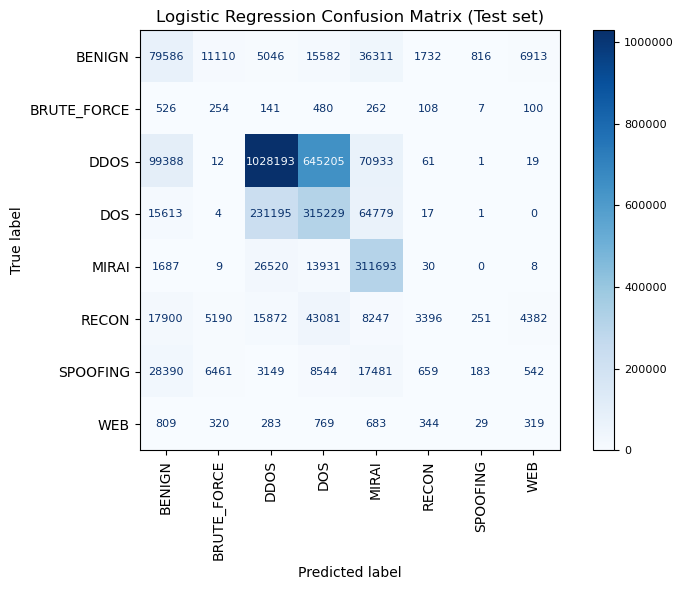

In [21]:
# Helper function to evaluate Logistic Regression on val/test
def evaluate_multiclass_model_logreg(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass Logistic Regression classifier with accuracy,
    precision, recall, macro/weighted F1, classification report,
    and confusion matrix.
    """
    y_pred_enc = pipeline.predict(X)
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== LOGISTIC REGRESSION {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nLogistic Regression Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    # save_table(report_df, f"LogisticRegression_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"Logistic Regression Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    # save_figure(fig, f"LogisticRegression_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }

# Evaluate Logistic Regression on validation and test sets

logreg_val_results = evaluate_multiclass_model_logreg(
    logreg_pipeline,
    X_val,
    y_val_enc,
    split_name="Val"
)

logreg_test_results = evaluate_multiclass_model_logreg(
    logreg_pipeline,
    X_test,
    y_test_enc,
    split_name="Test"
)

## Linear SVM Model

In [22]:
# Multiclass Linear SVM (LinearSVC) model development

numeric_transformer_svm = RobustScaler()
categorical_transformer_svm = OneHotEncoder(handle_unknown="ignore")

preprocessor_svm = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_svm, numeric_features),
        ("cat", categorical_transformer_svm, categorical_features),
    ]
)

# Define the Linear SVM classifier (LinearSVC)
svm_clf = LinearSVC(
    C=1.0,
    multi_class="ovr",     # one-vs-rest for multiclass
    max_iter=5000,         # bump iterations to help convergence
    dual=False,            # prefer dual=False when n_samples > n_features
    random_state=RANDOM_SEED
)

# Build the full modeling pipeline for Linear SVM
svm_pipeline = SKPipeline(
    steps=[
        ("preprocess", preprocessor_svm),
        ("model", svm_clf),
    ]
)

# Cross-validation on the balanced training data (reuse the same cv object)
cv_results_svm = cross_validate(
    svm_pipeline,
    X_train_bal,
    y_train_bal_enc,
    cv=cv,
    scoring=[
        "accuracy",
        "f1_macro", "f1_weighted",
        "precision_macro", "precision_weighted",
        "recall_macro", "recall_weighted",
    ],
    n_jobs=-1,
    return_train_score=False
)

cv_svm_df = pd.DataFrame(cv_results_svm)
cv_svm_summary = cv_svm_df[
    [
        "test_accuracy",
        "test_f1_macro", "test_f1_weighted",
        "test_precision_macro", "test_precision_weighted",
        "test_recall_macro", "test_recall_weighted",
    ]
].agg(["mean", "std"]).T

cv_svm_summary.columns = ["mean", "std"]

print("\nLinear SVM (LinearSVC) Cross-validation performance (balanced training set):")
print(cv_svm_summary)

# Optionally save CV results and summary for Linear SVM
# save_table(cv_svm_df, "LinearSVM_CV_Results.csv", index=False)
# save_table(cv_svm_summary, "LinearSVM_CV_Summary.csv", index=True)

# Fit the Linear SVM pipeline on the full balanced training set
svm_pipeline.fit(X_train_bal, y_train_bal_enc)


Linear SVM (LinearSVC) Cross-validation performance (balanced training set):
                             mean       std
test_accuracy            0.612249  0.001374
test_f1_macro            0.611128  0.000873
test_f1_weighted         0.611128  0.000882
test_precision_macro     0.639933  0.003196
test_precision_weighted  0.639933  0.003209
test_recall_macro        0.612249  0.001360
test_recall_weighted     0.612249  0.001374


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



=== LINEAR SVM VAL SET PERFORMANCE ===
Accuracy            : 0.7049
Precision (macro)   : 0.5517
Precision (weighted): 0.8189
Recall (macro)      : 0.6158
Recall (weighted)   : 0.7049
F1 (macro)          : 0.5285
F1 (weighted)       : 0.7262

Linear SVM Classification Report (Val):
              precision    recall  f1-score   support

      BENIGN     0.7735    0.5503    0.6431    157096
 BRUTE_FORCE     0.0657    0.3504    0.1106      1878
        DDOS     0.9377    0.6201    0.7465   1843812
         DOS     0.4409    0.8788    0.5872    626838
       MIRAI     0.9945    0.9899    0.9922    353877
       RECON     0.7545    0.5025    0.6032     98320
    SPOOFING     0.4151    0.5855    0.4858     65409
         WEB     0.0318    0.4485    0.0594      3556

    accuracy                         0.7049   3150786
   macro avg     0.5517    0.6158    0.5285   3150786
weighted avg     0.8189    0.7049    0.7262   3150786



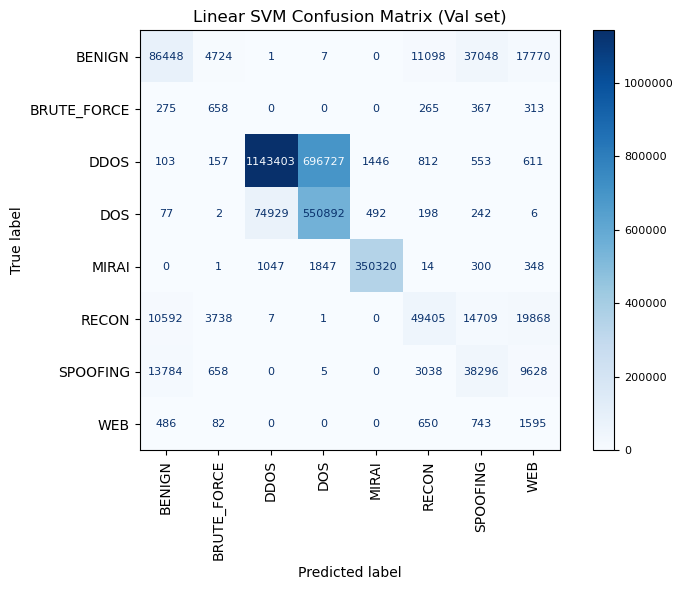


=== LINEAR SVM TEST SET PERFORMANCE ===
Accuracy            : 0.7052
Precision (macro)   : 0.5516
Precision (weighted): 0.8194
Recall (macro)      : 0.6127
Recall (weighted)   : 0.7052
F1 (macro)          : 0.5279
F1 (weighted)       : 0.7265

Linear SVM Classification Report (Test):
              precision    recall  f1-score   support

      BENIGN     0.7763    0.5506    0.6442    157096
 BRUTE_FORCE     0.0639    0.3445    0.1077      1878
        DDOS     0.9382    0.6203    0.7468   1843812
         DOS     0.4412    0.8797    0.5877    626838
       MIRAI     0.9944    0.9902    0.9923    353878
       RECON     0.7536    0.5008    0.6017     98319
    SPOOFING     0.4151    0.5874    0.4864     65409
         WEB     0.0303    0.4280    0.0566      3556

    accuracy                         0.7052   3150786
   macro avg     0.5516    0.6127    0.5279   3150786
weighted avg     0.8194    0.7052    0.7265   3150786



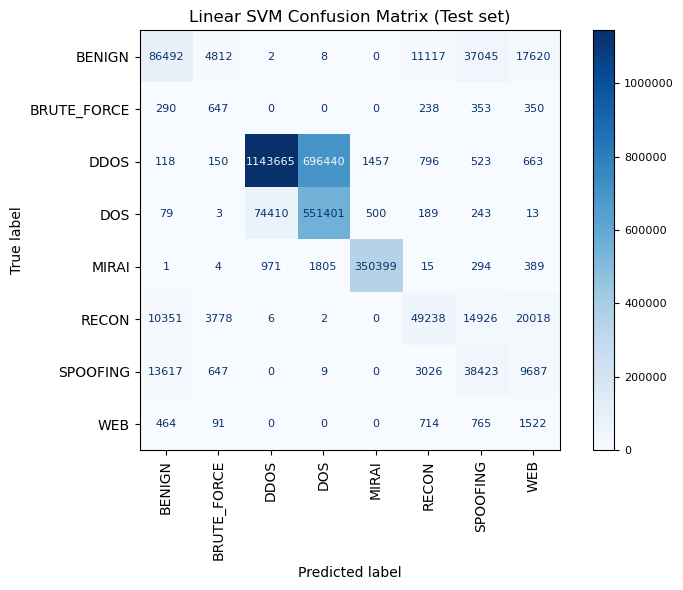

In [23]:
# Helper function to evaluate Linear SVM on val/test
def evaluate_multiclass_model_linearsvm(pipeline, X, y_true_enc, split_name="val"):
    """
    Evaluate a multiclass Linear SVM (LinearSVC) classifier with accuracy,
    precision, recall, macro/weighted F1, classification report,
    and confusion matrix.
    """
    y_pred_enc = pipeline.predict(X)

    # LinearSVC does not implement predict_proba; we keep this for API consistency
    y_pred_proba = None
    if hasattr(pipeline.named_steps["model"], "predict_proba"):
        y_pred_proba = pipeline.predict_proba(X)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== LINEAR SVM {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nLinear SVM Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    # save_table(report_df, f"LinearSVM_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"Linear SVM Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    # save_figure(fig, f"LinearSVM_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    # Return metrics in case we want to store them programmatically
    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }


# Evaluate Linear SVM on validation and test sets

svm_val_results = evaluate_multiclass_model_linearsvm(
    svm_pipeline,
    X_val,
    y_val_enc,
    split_name="Val"
)

svm_test_results = evaluate_multiclass_model_linearsvm(
    svm_pipeline,
    X_test,
    y_test_enc,
    split_name="Test"
)

## CNN Model

In [24]:
# Deep learning / CNN imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    InputLayer,
    Conv1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(RANDOM_SEED)


In [25]:
# ---------- Preprocessing for CNN (full imbalanced train set) ----------

numeric_transformer_cnn = RobustScaler()

# If you are on an older sklearn (<1.2), change sparse_output=False -> sparse=False
categorical_transformer_cnn = OneHotEncoder(
    handle_unknown="ignore",
    sparse_output=False
)

preprocessor_cnn = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_cnn, numeric_features),
        ("cat", categorical_transformer_cnn, categorical_features),
    ]
)

# Fit on the FULL (imbalanced) training data
X_train_full_proc = preprocessor_cnn.fit_transform(X_train_full)
X_val_proc = preprocessor_cnn.transform(X_val)
X_test_proc = preprocessor_cnn.transform(X_test)

# Ensure dense arrays in case anything is still sparse
if hasattr(X_train_full_proc, "toarray"):
    X_train_full_proc = X_train_full_proc.toarray()
    X_val_proc = X_val_proc.toarray()
    X_test_proc = X_test_proc.toarray()

# Reshape for 1D CNN: (n_samples, n_features, 1)
n_features_cnn = X_train_full_proc.shape[1]

X_train_cnn = X_train_full_proc.reshape(-1, n_features_cnn, 1)
X_val_cnn = X_val_proc.reshape(-1, n_features_cnn, 1)
X_test_cnn = X_test_proc.reshape(-1, n_features_cnn, 1)

print(f"1D CNN input shape (train): {X_train_cnn.shape}, n_classes: {n_classes}")

# ---------- Encode labels for full training set ----------

# label_encoder was already fit earlier on y_train_bal, which includes all classes
y_train_full_enc = label_encoder.transform(y_train_full)
# y_val_enc and y_test_enc already exist

# ---------- Compute class weights on FULL training distribution ----------

classes = np.unique(y_train_full_enc)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_full_enc
)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

# ---------- CNN model definition ----------

def build_cnn_model(input_shape, n_classes, learning_rate=1e-3):
    """
    Build a simple 1D CNN for multiclass classification on tabular data.
    """
    model = Sequential([
        InputLayer(input_shape=input_shape),

        Conv1D(filters=64, kernel_size=3, activation="relu", padding="same"),
        BatchNormalization(),

        Conv1D(filters=64, kernel_size=3, activation="relu", padding="same"),
        GlobalMaxPooling1D(),

        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.5),

        Dense(n_classes, activation="softmax")
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",  # integer labels
        metrics=["accuracy"],
    )

    return model

cnn_input_shape = (n_features_cnn, 1)
cnn_model_full = build_cnn_model(
    input_shape=cnn_input_shape,
    n_classes=n_classes,
    learning_rate=1e-3
)

cnn_model_full.summary()

# ---------- Training with Early Stopping and Class Weights ----------

early_stopping_cnn = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

cnn_history_full = cnn_model_full.fit(
    X_train_cnn,
    y_train_full_enc,
    validation_data=(X_val_cnn, y_val_enc),
    epochs=20,
    batch_size=1024,
    callbacks=[early_stopping_cnn],
    class_weight=class_weight_dict,
    verbose=1
)

1D CNN input shape (train): (14703668, 39, 1), n_classes: 8
Class weights: {0: 2.5070500439221077, 1: 209.71685303514377, 2: 0.2136054768844136, 3: 0.6283096823067349, 4: 1.1129510338930912, 5: 4.00579414809568, 6: 6.021296147659406, 7: 110.75375112985839}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 39, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 39, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 39, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,216 (86.78 KB)

 Trainable params: 22,088 (86.28 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/20
14360/14360 ━━━━━━━━━━━━━━━━━━━━ 256s 18ms/step - accuracy: 0.5820 - loss: 1.1690 - val_accuracy: 0.4483 - val_loss: 0.7899
Epoch 2/20
14360/14360 ━━━━━━━━━━━━━━━━━━━━ 260s 18ms/step - accuracy: 0.6349 - loss: 1.0152 - val_accuracy: 0.6525 - val_loss: 0.6611
Epoch 3/20
14360/14360 ━━━━━━━━━━━━━━━━━━━━ 261s 18ms/step - accuracy: 0.6432 - loss: 0.9733 - val_accuracy: 0.6203 - val_loss: 0.6521
Epoch 4/20
14360/14360 ━━━━━━━━━━━━━━━━━━━━ 263s 18ms/step - accuracy: 0.6504 - loss: 0.9496 - val_accuracy: 0.5719 - val_loss: 0.6824
Epoch 5/20
14360/14360 ━━━━━━━━━━━━━━━━━━━━ 268s 19ms/step - accuracy: 0.6524 - loss: 0.9373 - val_accuracy: 0.7165 - val_loss: 0.5734
Epoch 6/20
14360/14360 ━━━━━━━━━━━━━━━━━━━━ 270s 19ms/step - accuracy: 0.6551 - loss: 0.9271 - val_accuracy: 0.7116 - val_loss: 0.5698
Epoch 7/20
14360/14360 ━━━━━━━━━━━━━━━━━━━━ 270s 19ms/step - accuracy: 0.6521 - loss: 0.9201 - val_accuracy: 0.6632 - val_loss: 0.5866
Epoch 8/20
14360/14360 ━━━━━━━━━━━━━━━━━━━━ 267s 19ms/s

98463/98463 ━━━━━━━━━━━━━━━━━━━━ 122s 1ms/step

=== CNN VAL-FULL SET PERFORMANCE ===
Accuracy            : 0.7116
Precision (macro)   : 0.6042
Precision (weighted): 0.8092
Recall (macro)      : 0.5953
Recall (weighted)   : 0.7116
F1 (macro)          : 0.5339
F1 (weighted)       : 0.7374

CNN Classification Report (Val-Full):
              precision    recall  f1-score   support

      BENIGN     0.7861    0.5685    0.6598    157096
 BRUTE_FORCE     0.0107    0.6906    0.0210      1878
        DDOS     0.9024    0.6724    0.7706   1843812
         DOS     0.4498    0.7849    0.5719    626838
       MIRAI     0.9842    0.9815    0.9829    353877
       RECON     0.7654    0.3455    0.4761     98320
    SPOOFING     0.8629    0.5810    0.6944     65409
         WEB     0.0716    0.1384    0.0944      3556

    accuracy                         0.7116   3150786
   macro avg     0.6042    0.5953    0.5339   3150786
weighted avg     0.8092    0.7116    0.7374   3150786



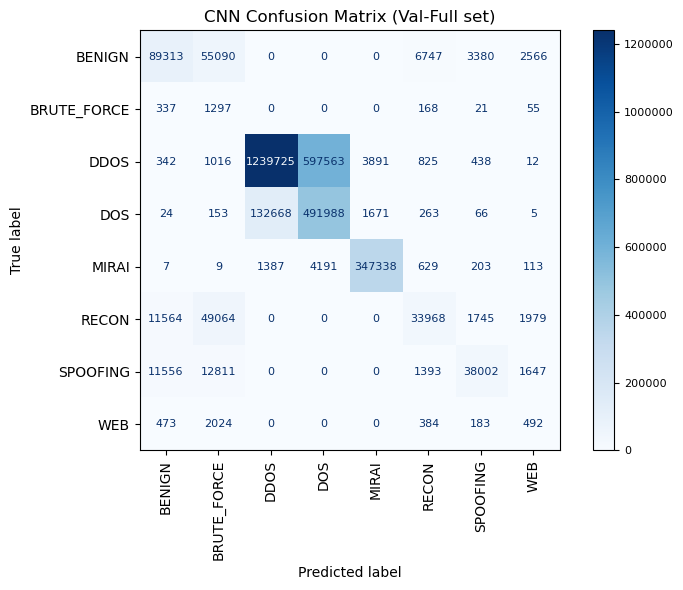

98463/98463 ━━━━━━━━━━━━━━━━━━━━ 149s 2ms/step

=== CNN TEST-FULL SET PERFORMANCE ===
Accuracy            : 0.7117
Precision (macro)   : 0.6042
Precision (weighted): 0.8094
Recall (macro)      : 0.5977
Recall (weighted)   : 0.7117
F1 (macro)          : 0.5342
F1 (weighted)       : 0.7375

CNN Classification Report (Test-Full):
              precision    recall  f1-score   support

      BENIGN     0.7884    0.5697    0.6615    157096
 BRUTE_FORCE     0.0109    0.7061    0.0216      1878
        DDOS     0.9025    0.6721    0.7704   1843812
         DOS     0.4498    0.7853    0.5720    626838
       MIRAI     0.9844    0.9822    0.9833    353878
       RECON     0.7649    0.3462    0.4766     98319
    SPOOFING     0.8636    0.5842    0.6969     65409
         WEB     0.0686    0.1355    0.0911      3556

    accuracy                         0.7117   3150786
   macro avg     0.6042    0.5977    0.5342   3150786
weighted avg     0.8094    0.7117    0.7375   3150786



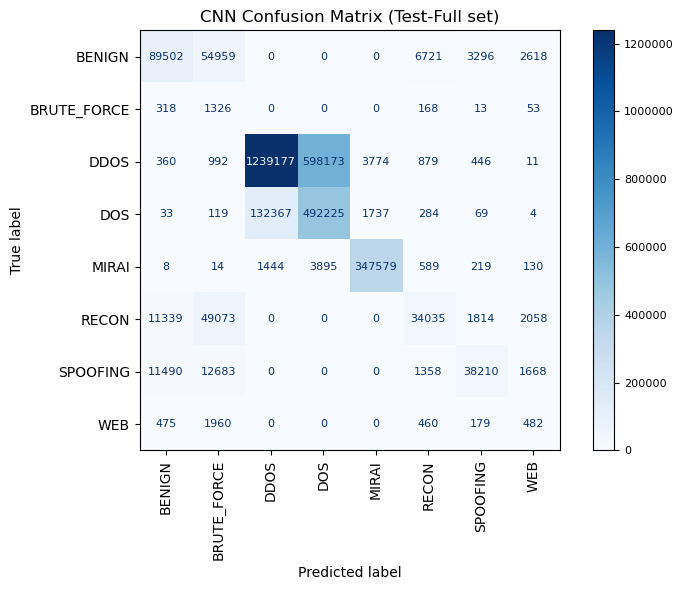

In [26]:
# Evaluation helpers for the CNN
def evaluate_multiclass_model_cnn(model, X_cnn, y_true_enc, split_name="val"):
    """
    Evaluate the 1D CNN multiclass classifier with accuracy, precision, recall,
    macro/weighted F1, classification report, and confusion matrix.
    """
    # Predict probabilities then convert to class indices
    y_pred_proba = model.predict(X_cnn)
    y_pred_enc = np.argmax(y_pred_proba, axis=1)

    # Basic metrics
    acc = accuracy_score(y_true_enc, y_pred_enc)
    f1_macro = f1_score(y_true_enc, y_pred_enc, average="macro")
    f1_weighted = f1_score(y_true_enc, y_pred_enc, average="weighted")

    precision_macro = precision_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    precision_weighted = precision_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    recall_macro = recall_score(
        y_true_enc, y_pred_enc, average="macro", zero_division=0
    )
    recall_weighted = recall_score(
        y_true_enc, y_pred_enc, average="weighted", zero_division=0
    )

    print(f"\n=== CNN {split_name.upper()} SET PERFORMANCE ===")
    print(f"Accuracy            : {acc:.4f}")
    print(f"Precision (macro)   : {precision_macro:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (macro)      : {recall_macro:.4f}")
    print(f"Recall (weighted)   : {recall_weighted:.4f}")
    print(f"F1 (macro)          : {f1_macro:.4f}")
    print(f"F1 (weighted)       : {f1_weighted:.4f}")

    # Classification report with readable class names
    report = classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        digits=4
    )
    print(f"\nCNN Classification Report ({split_name}):")
    print(report)

    # Optionally save classification report as a table
    report_dict = metrics.classification_report(
        y_true_enc,
        y_pred_enc,
        target_names=class_names,
        output_dict=True
    )
    report_df = pd.DataFrame(report_dict).T
    # save_table(report_df, f"CNN_{split_name}_Classification_Report.csv", index=True)

    # Confusion matrix
    cm = confusion_matrix(y_true_enc, y_pred_enc)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, values_format='d', colorbar=False)

    # Make the numbers inside the cells smaller
    for txt in disp.text_.ravel():
        txt.set_fontsize(8)

    # Add a colorbar without scientific notation
    cbar = fig.colorbar(disp.im_, ax=ax, format="%.0f")
    cbar.ax.tick_params(labelsize=8)

    ax.set_title(f"CNN Confusion Matrix ({split_name} set)")
    plt.tight_layout()

    # save_figure(fig, f"CNN_{split_name}_Confusion_Matrix.png", dpi=300)
    plt.show()
    plt.close(fig)

    return {
        "accuracy": acc,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted,
        "recall_macro": recall_macro,
        "recall_weighted": recall_weighted,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "y_pred_enc": y_pred_enc,
        "y_pred_proba": y_pred_proba,
    }

# ---------- Evaluate CNN on validation and test sets ----------

cnn_val_results_full = evaluate_multiclass_model_cnn(
    cnn_model_full,
    X_val_cnn,
    y_val_enc,
    split_name="Val-Full"
)

cnn_test_results_full = evaluate_multiclass_model_cnn(
    cnn_model_full,
    X_test_cnn,
    y_test_enc,
    split_name="Test-Full"
)


# RNN Model

## LSTM Model